# Jax Level 0 Data Scientist Experience - Chapter 9 - Getting started with Jax MLPs, CNNs, and RNNs

Link to the original blog post by Robert Tjarko Lange: https://roberttlange.com/posts/2020/03/blog-post-10/

In [1]:
# Import the necessary libraries
import syft as sy
sy.requires(">=0.8-beta")
import jax
import jax.numpy as jnp

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


✅ The installed version of syft==0.8.1b1 matches the requirement >=0.8b0


## Part 1 - User login and code execution requests

In [2]:
# Register a client to the domain
node = sy.orchestra.launch(name="test-domain-1")
guest_domain_client = node.client
guest_domain_client.register(name="Jane Doe", email="jane@caltech.edu", password="abc123", institution="Caltech", website="https://www.caltech.edu/")
guest_domain_client.login(email="jane@caltech.edu", password="abc123")

SQLite Store Path:
!open file:///var/folders/sz/hkfsnn612hq56r7cs5rd540r0000gn/T/7bca415d13ed1ec841f0d0aede098dbb.sqlite



<SyftClient - test-domain-1 <7bca415d13ed1ec841f0d0aede098dbb>: PythonConnection>

### What is this JAX thing?

In [4]:
# Create a function for code execution
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def func_dot_time_comparison():
    # Note: using different naming conventions for numpy and jax
    # compared to the original blog post, i.e. onp => np, np => jnp.
    import numpy as np
    import jax.numpy as jnp
    from jax import random

    # Generate key which is used to generate random numbers
    key = random.PRNGKey(1)

    # Generate a random matrix
    x = random.uniform(key, (1000, 1000))
    # Compare running times of 3 different matrix multiplications
    %time y = np.dot(x, x)
    %time y = jnp.dot(x, x)
    %time y = jnp.dot(x, x).block_until_ready()

### A Few Basic Concepts & Conventions - jit, grad & vmap

In [5]:
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def func_jit():
    # Note: using different naming conventions for numpy and jax
    # compared to the original blog post, i.e. onp => np, np => jnp.
    import numpy as np
    import jax.numpy as jnp
    from jax import random, jit, grad

    def ReLU(x):
        """ Rectified Linear Unit (ReLU) activation function """
        return jnp.maximum(0, x)
    
    key = random.PRNGKey(1)
    x = random.uniform(key, (1000, 1000))

    jit_ReLU = jit(ReLU)

    %time out = ReLU(x).block_until_ready()
    # Call jitted version to compile for evaluation time!
    %time jit_ReLU(x).block_until_ready()
    %time out = jit_ReLU(x).block_until_ready()

In [6]:
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def func_grad():
    # Note: using different naming conventions for numpy and jax
    # compared to the original blog post, i.e. onp => np, np => jnp.
    import numpy as np
    import jax.numpy as jnp
    from jax import random, jit, grad

    # NOTE: using the same ReLU function as in the previous example
    def ReLU(x):
        """ Rectified Linear Unit (ReLU) activation function """
        return jnp.maximum(0, x)
    
    def FiniteDiffGrad(x):
        """ Compute the finite difference derivative approx for the ReLU"""
        return np.array((ReLU(x + 1e-3) - ReLU(x - 1e-3)) / (2 * 1e-3))
    
    key = random.PRNGKey(1)
    x = random.uniform(key, (1000, 1000))

    # Compare the Jax gradient with a finite difference approximation
    print("Jax Grad: ", jit(grad(jit(ReLU)))(2.))
    print("FD Gradient:", FiniteDiffGrad(2.))

In [7]:
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def func_vmap():
    # Note: using different naming conventions for numpy and jax
    # compared to the original blog post, i.e. onp => np, np => jnp.
    import numpy as np
    import jax.numpy as jnp
    from jax import random, jit, vmap

    batch_dim = 32
    feature_dim = 100
    hidden_dim = 512

    # Generate a batch of vectors to process
    key = random.PRNGKey(1)
    X = random.normal(key, (batch_dim, feature_dim))

    # Generate Gaussian weights and biases
    params = [random.normal(key, (hidden_dim, feature_dim)),
            random.normal(key, (hidden_dim, ))]
    
    # NOTE: using the same ReLU function as in the previous example
    def ReLU(x):
        """ Rectified Linear Unit (ReLU) activation function """
        return jnp.maximum(0, x)

    def relu_layer(params, x):
        """ Simple ReLu layer for single sample """
        return ReLU(np.dot(params[0], x) + params[1])

    def batch_version_relu_layer(params, x):
        """ Error prone batch version """
        return ReLU(np.dot(X, params[0].T) + params[1])

    def vmap_relu_layer(params, x):
        """ vmap version of the ReLU layer """
        return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

    out = np.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])
    out = batch_version_relu_layer(params, X)
    out = vmap_relu_layer(params, X)    

In [8]:
# Test our functions locally
# func_dot_time_comparison()
"""
NOTE: running time comparison results differ from the ones on the blog post:
CPU times: user 45.3 ms, sys: 6.12 ms, total: 51.5 ms
Wall time: 16 ms
CPU times: user 24.1 ms, sys: 3.28 ms, total: 27.4 ms
Wall time: 6.85 ms
CPU times: user 149 ms, sys: 23 ms, total: 172 ms
Wall time: 30.4 ms
"""

# func_jit()
# func_grad()
# func_vmap()

'\nNOTE: running time comparison results differ from the ones on the blog post:\nCPU times: user 45.3 ms, sys: 6.12 ms, total: 51.5 ms\nWall time: 16 ms\nCPU times: user 24.1 ms, sys: 3.28 ms, total: 27.4 ms\nWall time: 6.85 ms\nCPU times: user 149 ms, sys: 23 ms, total: 172 ms\nWall time: 30.4 ms\n'

In [9]:
# Submit the function for code execution
# guest_domain_client.api.services.code.request_code_execution(func_dot_time_comparison)
# guest_domain_client.api.services.code.request_code_execution(func_jit)
# guest_domain_client.api.services.code.request_code_execution(func_grad)
guest_domain_client.api.services.code.request_code_execution(func_vmap)


<class 'syft.service.response.SyftError'>: Duplication Key Error: syft.service.code.user_code.UserCode

## Part 3
### Training a MNIST Multilayer Perceptron in JAX

In [10]:
# seaborn used by helpers.py
%pip install seaborn

You should consider upgrading via the '/Users/antti/.pyenv/versions/3.10.4/envs/jax_1/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
results = guest_domain_client.api.services.dataset.get_all()

In [ ]:
dataset = results[0]
dataset

In [ ]:
mock = dataset.assets[0].mock
mock

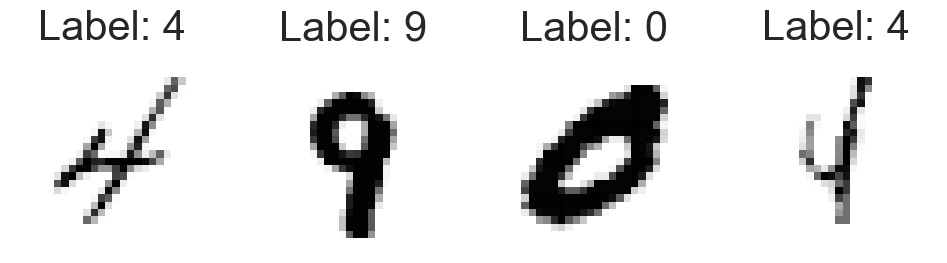

In [12]:
import numpy as np
import time
from helpers import plot_mnist_examples

# Set the batch size
batch_size = 100

# TODO: use the received dataset
train_data = None
train_labels = None
test_data = None
test_labels = None

# Shuffle the training data
shuffle_indices = np.random.permutation(len(train_data))
train_data = train_data[shuffle_indices]
train_labels = train_labels[shuffle_indices]

# Calculate the number of batches
num_train_batches = len(train_data) // batch_size
num_test_batches = len(test_data) // batch_size

# Create a function to retrieve a batch of data
def get_batch(data, labels, batch_idx, batch_size):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size
    return data[start_idx:end_idx], labels[start_idx:end_idx]

# Plot MNIST examples
plot_mnist_examples(train_data, train_labels)




In [17]:
@sy.syft_function(input_policy=sy.ExactMatch(
                    data=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def func_mlp(data):
    # Import some additional JAX
    from jax.scipy.special import logsumexp
    from jax.experimental import optimizers
    from jax import random, jit, grad, vmap, value_and_grad

    key = random.PRNGKey(1)

    def ReLU(x):
        """ Rectified Linear Unit (ReLU) activation function """
        return np.maximum(0, x)

    def relu_layer(params, x):
        """ Simple ReLu layer for single sample """
        return ReLU(np.dot(params[0], x) + params[1])

    def initialize_mlp(sizes, key):
        """ Initialize the weights of all layers of a linear layer network """
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, key, scale=1e-2):
            w_key, b_key = random.split(key)
            return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
        return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

    layer_sizes = [784, 512, 512, 10]
    # Return a list of tuples of layer weights
    params = initialize_mlp(layer_sizes, key)

    num_epochs = 10
    num_classes = 10

    def forward_pass(params, in_array):
        """ Compute the forward pass for each example individually """
        activations = in_array

        # Loop over the ReLU hidden layers
        for w, b in params[:-1]:
            activations = relu_layer([w, b], activations)

        # Perform final trafo to logits
        final_w, final_b = params[-1]
        logits = np.dot(final_w, activations) + final_b
        return logits - logsumexp(logits)

    # Make a batched version of the `predict` function
    batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

    # For logging purposes we compute the accuracy as well
    def one_hot(x, k, dtype=np.float32):
        """Create a one-hot encoding of x of size k """
        return np.array(x[:, None] == np.arange(k), dtype)

    def loss(params, in_arrays, targets):
        """ Compute the multi-class cross-entropy loss """
        preds = batch_forward(params, in_arrays)
        return -np.sum(preds * targets)

    def accuracy(params, data, labels):
        """ Compute the accuracy for a provided dataloader """
        acc_total = 0
        num_samples = len(data)
        for i in range(num_samples):
            images = data.reshape(data.shape[0], 28*28)
            target = labels[i]
            targets = one_hot(np.array(target), num_classes)

            target_class = np.argmax(targets, axis=1)
            predicted_class = np.argmax(batch_forward(params, images), axis=1)
            acc_total += np.sum(predicted_class == target_class)
        return acc_total/num_samples
    
    @jit
    def update(params, x, y, opt_state):
        """ Compute the gradient for a batch and update the parameters """
        value, grads = value_and_grad(loss)(params, x, y)
        opt_state = opt_update(0, grads, opt_state)
        return get_params(opt_state), opt_state, value

    # Defining an optimizer in Jax
    step_size = 1e-3
    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(params)

    def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
        """ Implements a learning loop over epochs. """
        # Initialize placeholder for loggin
        log_acc_train, log_acc_test, train_loss = [], [], []

        # Get the initial set of parameters
        params = get_params(opt_state)

        # Get initial accuracy after random init
        train_acc = accuracy(params, train_data, train_labels)
        test_acc = accuracy(params, test_data, test_labels)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)

        # Loop over the training epochs
        for epoch in range(num_epochs):
            start_time = time.time()
            num_train_samples = len(train_data)
            for i in range(num_train_batches):
                # Get a batch of data
                start_idx = i * batch_size
                end_idx = (i + 1) * batch_size
                data = train_data[start_idx:end_idx]
                target = train_labels[start_idx:end_idx]

                if net_type == "MLP":
                    # Flatten the image into 784 vectors for the MLP
                    x = np.array(data).reshape(data.size(0), 28*28)
                elif net_type == "CNN":
                    # No flattening of the input required for the CNN
                    x = np.array(data)
                y = one_hot(np.array(target), num_classes)
                params, opt_state, loss = update(params, x, y, opt_state)
                train_loss.append(loss)

            epoch_time = time.time() - start_time
            train_acc = accuracy(params, train_data, train_labels)
            test_acc = accuracy(params, test_data, test_labels)
            log_acc_train.append(train_acc)
            log_acc_test.append(test_acc)
            print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                        train_acc, test_acc))

        return train_loss, log_acc_train, log_acc_test


    train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                            opt_state,
                                                            net_type="MLP")
    

# from helpers import plot_mnist_performance
# plot_mnist_performance(train_loss, train_log, test_log,
#                        "MNIST MLP Performance")


In [ ]:
# Test our functions locally
func_mlp(data=mock)

## Part 5
### Using the stax API to build Sequential Models - Case Study: A CNN

In [1]:
@sy.syft_function(input_policy=sy.ExactMatch(
                    data=mock),
                  output_policy=sy.SingleExecutionExactOutput())
def func_cnn(data):
  from jax import random, value_and_grad, jit
  from jax.experimental import stax, optimizers
  from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                    Relu, LogSoftmax)
  
  key = random.PRNGKey(1)
  num_classes = 10
  
  # NOTE: ** copy&pasted from func_mlp. Any way to share code?
  def one_hot(x, k, dtype=np.float32):
        """Create a one-hot encoding of x of size k """
        return np.array(x[:, None] == np.arange(k), dtype)
  
  @jit
  def update(params, x, y, opt_state):
        """ Compute the gradient for a batch and update the parameters """
        value, grads = value_and_grad(loss)(params, x, y)
        opt_state = opt_update(0, grads, opt_state)
        return get_params(opt_state), opt_state, value
  
  
  def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
        """ Implements a learning loop over epochs. """
        # Initialize placeholder for loggin
        log_acc_train, log_acc_test, train_loss = [], [], []

        # Get the initial set of parameters
        params = get_params(opt_state)

        # Get initial accuracy after random init
        train_acc = accuracy(params, train_data, train_labels)
        test_acc = accuracy(params, test_data, test_labels)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)

        # Loop over the training epochs
        for epoch in range(num_epochs):
            start_time = time.time()
            num_train_samples = len(train_data)
            for i in range(num_train_batches):
                # Get a batch of data
                start_idx = i * batch_size
                end_idx = (i + 1) * batch_size
                data = train_data[start_idx:end_idx]
                target = train_labels[start_idx:end_idx]

                if net_type == "MLP":
                    # Flatten the image into 784 vectors for the MLP
                    x = np.array(data).reshape(data.size(0), 28*28)
                elif net_type == "CNN":
                    # No flattening of the input required for the CNN
                    x = np.array(data)
                y = one_hot(np.array(target), num_classes)
                params, opt_state, loss = update(params, x, y, opt_state)
                train_loss.append(loss)

            epoch_time = time.time() - start_time
            train_acc = accuracy(params, train_data, train_labels)
            test_acc = accuracy(params, test_data, test_labels)
            log_acc_train.append(train_acc)
            log_acc_test.append(test_acc)
            print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                        train_acc, test_acc))

        return train_loss, log_acc_train, log_acc_test
  # end of copy&paste **
  
  init_fun, conv_net = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
                                 Flatten,
                                 Dense(num_classes),
                                 LogSoftmax)

  _, params = init_fun(key, (batch_size, 1, 28, 28))

  def accuracy(params, data_loader):
    """ Compute the accuracy for the CNN case (no flattening of input)"""
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(conv_net(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

  def loss(params, images, targets):
      preds = conv_net(params, images)
      return -np.sum(preds * targets)
  
  step_size = 1e-3
  opt_init, opt_update, get_params = optimizers.adam(step_size)
  opt_state = opt_init(params)
  num_epochs = 10

  train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                            opt_state,
                                                            net_type="CNN")


# Plot the loss curve over time
# from helpers import plot_mnist_performance
# plot_mnist_performance(train_loss, train_log, test_log,
#                        "MNIST MLP Performance")

IndentationError: unexpected indent (695301393.py, line 18)